# how does the density of inflow into the Salish Sea vary? 

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import cmocean as cm
import gsw
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec
import matplotlib.lines as mlines


# Hovomoller of inflow density to the Salish Sea
Analysis according to SalishSeaCast monthly climatology

In [3]:
clim = xr.open_dataset('/results2/SalishSea/month-avg.202111/SalishSeaCast_month_climatology_grid_T_20070101_20231231.nc')

In [4]:
# lets start by using a single point in the middle of the JdF in the PRT
xpoint, ypoint = 44, 375


In [5]:
# calculate density anomaly
S_pt = clim['vosaline'].isel(gridX=44, gridY=375,depth=slice(0, 31)).values
CT = clim['votemper'].isel(gridX=44, gridY=375,depth=slice(0, 31)).values
sigma = gsw.density.sigma0(S_pt,CT)

<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_3455153/1734325333.py:20: SyntaxWarning: invalid escape sequence '\s'
  cbar.set_label('$\sigma_0$')


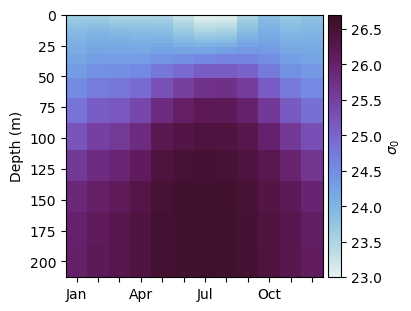

In [6]:

months = range(1,13)
depths = clim.depth[:31].values #[clim.depth[:31].values for i in range(12)]
MM, DD = np.meshgrid(months, depths)  # both (31, 12)


fig, ax = plt.subplots(figsize=(4, 3), constrained_layout=True)
pcm = ax.pcolormesh(
    MM, DD, sigma.T,
    cmap=cm.cm.dense, shading='nearest',
    vmin=23,vmax=26.7
)


# ax.set_xlabel('Month')
ax.set_ylabel('Depth (m)')
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan','','','Apr','','','Jul','','','Oct','',''])
ax.invert_yaxis()  # depth increases downward
cbar = fig.colorbar(pcm, ax=ax, pad=0.02)
cbar.set_label('$\sigma_0$')

# ax.set_title("Hovmöller of $\sigma_0$ at (gridX=44, gridY=375)")
plt.show()


# densities of the different water sources

In [7]:
def weighted_percentile(data, percentiles, weights=None):
    # Compute weighted percentiles
    data = np.asarray(data)
    if weights is None:
        weights = np.ones_like(data)
    else:
        weights = np.asarray(weights)

    # Ensure 1D inputs
    data = data.ravel()
    weights = weights.ravel()

    # Sort data and weights by data
    sorter = np.argsort(data)
    data_sorted = data[sorter]
    weights_sorted = weights[sorter]

    # Compute cumulative sum of weights
    cum_weights = np.cumsum(weights_sorted)
    cum_weights /= cum_weights[-1]

    # Handle scalar percentile input
    is_scalar = np.isscalar(percentiles)
    percentiles = np.atleast_1d(percentiles)

    # Interpolate
    result = np.interp(percentiles / 100, cum_weights, data_sorted)
    return result[0] if is_scalar else result

In [8]:
iso = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/isopycnals.csv')
iso

,Unnamed: 0,transport,section,Fsalt,Ftemp,Fdepth,Isalt,Itemp,Idepth,Iisopycnal,Fisopycnal,wm
0,0,303.159669,2.0,31.105961,10.294305,3.438488,31.646496,9.412666,16.192689,24.315739,23.753801,fresh
1,1,248.254126,2.0,29.523134,10.287880,1.907283,31.678185,9.356211,19.699151,24.349285,22.527707,fresh
2,2,55.977753,2.0,31.234024,10.248661,7.402451,31.439941,9.402411,-0.364622,24.156470,23.860721,fresh
3,3,130.880503,2.0,32.200840,9.578118,10.930170,31.501966,9.556664,-0.359163,24.180417,24.720389,south
4,4,175.226405,2.0,31.977562,10.253628,4.048908,31.562321,9.619990,-0.339634,24.217274,24.436571,fresh
...,...,...,...,...,...,...,...,...,...,...,...,...
8051611,8051611,155.311418,2.0,33.357948,8.394279,133.957248,30.835705,9.577654,1.486330,23.659401,25.806897,south
8051612,8051612,92.861807,2.0,28.504204,11.535708,1.405245,30.577766,9.926714,1.709969,23.403773,21.531012,fresh
8051613,8051613,96.576184,2.0,28.716646,8.948765,7.320068,30.579832,9.921121,2.506624,23.406285,22.107045,fresh
8051614,8051614,98.258461,2.0,30.082037,10.156914,11.068542,30.581558,9.916745,2.926434,23.408332,22.982335,fresh


In [9]:
print("CUC - mean: {}, range: {}-{}".format(np.average(iso.Fisopycnal[iso.wm=='cuc'],weights=iso.transport[iso.wm=='cuc']),
                                                weighted_percentile(iso.Fisopycnal[iso.wm=='cuc'],25,iso.transport[iso.wm=='cuc']),
                                                weighted_percentile(iso.Fisopycnal[iso.wm=='cuc'],75,iso.transport[iso.wm=='cuc'])))
print("offshore deep - mean: {}, min: {}, max: {}".format(np.average(iso.Fisopycnal[iso.wm=='offshore deep'],weights=iso.transport[iso.wm=='offshore deep']),
                                                weighted_percentile(iso.Fisopycnal[iso.wm=='offshore deep'],25,iso.transport[iso.wm=='offshore deep']),
                                                weighted_percentile(iso.Fisopycnal[iso.wm=='offshore deep'],75,iso.transport[iso.wm=='offshore deep'])))
print("offshore surface - mean: {}, min: {}, max: {}".format(np.average(iso.Fisopycnal[iso.wm=='offshore surface'],weights=iso.transport[iso.wm=='offshore surface']),
                                                weighted_percentile(iso.Fisopycnal[iso.wm=='offshore surface'],25,iso.transport[iso.wm=='offshore surface']),
                                                weighted_percentile(iso.Fisopycnal[iso.wm=='offshore surface'],75,iso.transport[iso.wm=='offshore surface'])))
print("north - mean: {}, min: {}, max: {}".format(np.average(iso.Fisopycnal[iso.wm=='north'],weights=iso.transport[iso.wm=='north']),
                                                weighted_percentile(iso.Fisopycnal[iso.wm=='north'],25,iso.transport[iso.wm=='north']),
                                                weighted_percentile(iso.Fisopycnal[iso.wm=='north'],75,iso.transport[iso.wm=='north'])))
print("south - mean: {}, min: {}, max: {}".format(np.average(iso.Fisopycnal[iso.wm=='south'],weights=iso.transport[iso.wm=='south']),
                                                weighted_percentile(iso.Fisopycnal[iso.wm=='south'],25,iso.transport[iso.wm=='south']),
                                                weighted_percentile(iso.Fisopycnal[iso.wm=='south'],75,iso.transport[iso.wm=='south'])))
print("fresh - mean: {}, min: {}, max: {}".format(np.average(iso.Fisopycnal[iso.wm=='fresh'],weights=iso.transport[iso.wm=='fresh']),
                                                weighted_percentile(iso.Fisopycnal[iso.wm=='fresh'],25,iso.transport[iso.wm=='fresh']),
                                                weighted_percentile(iso.Fisopycnal[iso.wm=='fresh'],75,iso.transport[iso.wm=='fresh'])))

CUC - mean: 26.449642479245817, range: 26.304562753417862-26.607585562574613
offshore deep - mean: 26.33989953440082, min: 26.14963868451589, max: 26.550870942576957
offshore surface - mean: 25.30269581652003, min: 25.113752113364743, max: 25.63463233032082
north - mean: 25.81067328419227, min: 25.51607952101866, max: 26.206910496377727
south - mean: 25.232473910140964, min: 24.84887878526146, max: 25.707166243345704
fresh - mean: 22.90426323702006, min: 22.236803498897057, max: 23.840574077515413


In [10]:
# total getting in - what's the mean water mass Fisopycnal?
print("total - mean: {}, q25: {}, q75: {}".format(np.average(iso.Fisopycnal,weights=iso.transport),
                                                weighted_percentile(iso.Fisopycnal,25,iso.transport),
                                                weighted_percentile(iso.Fisopycnal,75,iso.transport)))

print("total - mean: {}, q25: {}, q75: {}".format(np.average(iso.Iisopycnal,weights=iso.transport),
                                                weighted_percentile(iso.Iisopycnal,25,iso.transport),
                                                weighted_percentile(iso.Iisopycnal,75,iso.transport)))

total - mean: 25.70752588436572, q25: 25.346889460435843, q75: 26.46236759199903
total - mean: 25.73536275411627, q25: 25.680246089195744, q75: 26.290670949068712


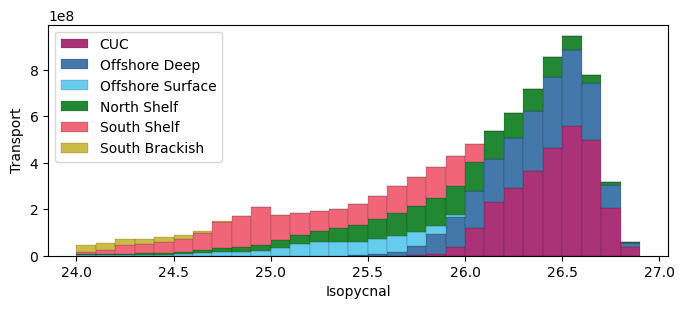

In [11]:
# densities at outer boundaries

fig, ax = plt.subplots(1, 1, figsize=[8, 3])
bins = np.arange(24.0, 27.0, 0.1)

datasets = [
    iso.Fisopycnal[iso.wm == 'cuc'],
    iso.Fisopycnal[iso.wm == 'offshore deep'],
    iso.Fisopycnal[iso.wm == 'offshore surface'],
    iso.Fisopycnal[iso.wm == 'north'],
    iso.Fisopycnal[iso.wm == 'south'],
    iso.Fisopycnal[iso.wm == 'fresh']
]

weights = [
    iso.transport[iso.wm == 'cuc'],
    iso.transport[iso.wm == 'offshore deep'],
    iso.transport[iso.wm == 'offshore surface'],
    iso.transport[iso.wm == 'north'],
    iso.transport[iso.wm == 'south'],
    iso.transport[iso.wm == 'fresh']
]

colors = ['#AA3377', '#4477AA', '#66CCEE', '#228833', '#EE6677', '#CCBB44']
labels = ['CUC', 'Offshore Deep', 'Offshore Surface', 'North Shelf', 'South Shelf', 'South Brackish']

ax.hist(
    datasets,
    bins=bins,
    weights=weights,
    color=colors,
    label=labels,
    stacked=True,
    edgecolor='black',
    linewidth = 0.1
)

ax.set_xlabel("Isopycnal")
ax.set_ylabel("Transport")
ax.legend()

In [13]:
# how much of the north water is from the top 200 m?
np.nansum(iso.transport[(iso.wm=='north')&(iso.Fdepth<200)])/np.nansum(iso.transport[iso.wm=='north'])

np.float64(0.8500775434491702)

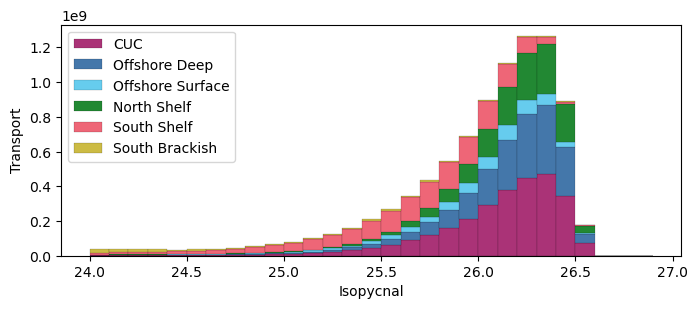

In [14]:
# density at JdF

fig, ax = plt.subplots(1, 1, figsize=[8, 3])
bins = np.arange(24.0, 27.0, 0.1)

datasets = [
    iso.Iisopycnal[iso.wm == 'cuc'],
    iso.Iisopycnal[iso.wm == 'offshore deep'],
    iso.Iisopycnal[iso.wm == 'offshore surface'],
    iso.Iisopycnal[iso.wm == 'north'],
    iso.Iisopycnal[iso.wm == 'south'],
    iso.Iisopycnal[iso.wm == 'fresh']

]

weights = [
    iso.transport[iso.wm == 'cuc'],
    iso.transport[iso.wm == 'offshore deep'],
    iso.transport[iso.wm == 'offshore surface'],
    iso.transport[iso.wm == 'north'],
    iso.transport[iso.wm == 'south'],
    iso.transport[iso.wm == 'fresh']

]

# colors = ['#AA3377', '#4477AA', '#66CCEE', '#228833', '#EE6677', '#CCBB44']
# labels = ['cuc', 'offshore deep', 'offshore surface', 'north', 'south', 'fresh']

ax.hist(
    datasets,
    bins=bins,
    weights=weights,
    color=colors,
    label=labels,
    stacked=True,
    edgecolor='black',
    linewidth = 0.1
)

ax.set_xlabel("Isopycnal")
ax.set_ylabel("Transport")
ax.legend()

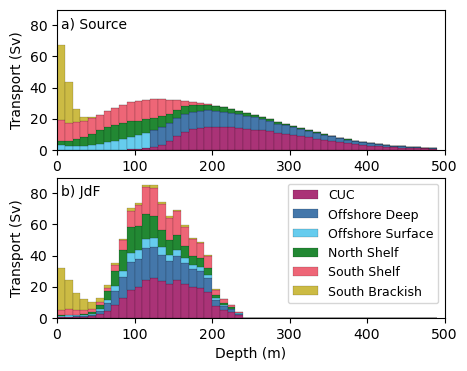

In [23]:
# depth
fig, ax = plt.subplots(2,1,figsize=[5,4])
bins = np.arange(0, 500, 10)
colors = ['#AA3377', '#4477AA', '#66CCEE', '#228833', '#EE6677', '#CCBB44']
labels = ['CUC', 'Offshore Deep', 'Offshore Surface', 'North Shelf', 'South Shelf', 'South Brackish']

# source
datasets = [
    iso.Fdepth[iso.wm == 'cuc'],
    iso.Fdepth[iso.wm == 'offshore deep'],
    iso.Fdepth[iso.wm == 'offshore surface'],
    iso.Fdepth[iso.wm == 'north'],
    iso.Fdepth[iso.wm == 'south'],
    iso.Fdepth[iso.wm == 'fresh']
]

weights = [
    iso.transport[iso.wm == 'cuc'],
    iso.transport[iso.wm == 'offshore deep'],
    iso.transport[iso.wm == 'offshore surface'],
    iso.transport[iso.wm == 'north'],
    iso.transport[iso.wm == 'south'],
    iso.transport[iso.wm == 'fresh']
]

ax[0].hist(
    datasets,
    bins=bins,
    weights=weights,
    color=colors,
    label=labels,
    stacked=True,
    edgecolor='black',
    linewidth = 0.1
)

# JdF
datasets = [
    iso.Idepth[iso.wm == 'cuc'],
    iso.Idepth[iso.wm == 'offshore deep'],
    iso.Idepth[iso.wm == 'offshore surface'],
    iso.Idepth[iso.wm == 'north'],
    iso.Idepth[iso.wm == 'south'],
    iso.Idepth[iso.wm == 'fresh']
]

weights = [
    iso.transport[iso.wm == 'cuc'],
    iso.transport[iso.wm == 'offshore deep'],
    iso.transport[iso.wm == 'offshore surface'],
    iso.transport[iso.wm == 'north'],
    iso.transport[iso.wm == 'south'],
    iso.transport[iso.wm == 'fresh']
]

ax[1].hist(
    datasets,
    bins=bins,
    weights=weights,
    color=colors,
    label=labels,
    stacked=True,
    edgecolor='black',
    linewidth = 0.1
)

# formatting 
for axs in [ax[0],ax[1]]:
    axs.set_ylabel("Transport (Sv)")
    axs.set_ylim([0,900000000])
    axs.set_yticks([0,200000000,400000000,600000000,800000000])
    axs.set_yticklabels([0,20,40,60,80])
    axs.set_xlim([0,500])

ax[1].legend(loc='best',fontsize=9)
ax[0].text(.01, .85, 'a) Source', ha='left', va='bottom', transform=ax[0].transAxes, fontsize=10)
ax[1].text(.01, .85, 'b) JdF', ha='left', va='bottom', transform=ax[1].transAxes, fontsize=10)
ax[1].set_xlabel('Depth (m)')

plt.savefig("/ocean/rbeutel/MOAD/biogeo_paper/PI_BIOGEO_PAPER/model/figures/depth_hist.jpg",bbox_inches='tight')

# Density attribution

In [36]:
def decomp(data,base):
    # slight variation in euation from other attribution file
    # not dividing by transport - so looking at flux of a property instead of just mean property change
    d = {'section':['salish','cuc', 'off_d', 'off_s', 'north', 'south', 'fresh','loop'],
        'saltP':np.zeros(8),'saltQ':np.zeros(8),'saltX':np.zeros(8),'saltSUM':np.zeros(8),
        'tempP':np.zeros(8),'tempQ':np.zeros(8),'tempX':np.zeros(8),'tempSUM':np.zeros(8),
        'DOP':np.zeros(8),'DOQ':np.zeros(8),'DOX':np.zeros(8),'DOSUM':np.zeros(8),
        'TAP':np.zeros(8),'TAQ':np.zeros(8),'TAX':np.zeros(8),'TASUM':np.zeros(8),
        'NO3P':np.zeros(8),'NO3Q':np.zeros(8),'NO3X':np.zeros(8),'NO3SUM':np.zeros(8),
        'DICP':np.zeros(8),'DICQ':np.zeros(8),'DICX':np.zeros(8),'DICSUM':np.zeros(8),
        'TADICP':np.zeros(8),'TADICQ':np.zeros(8),'TADICX':np.zeros(8),'TADICSUM':np.zeros(8)}
    df = pd.DataFrame(d)

    # salt
    df['saltP'] = (data.salt[1:] - base.salt[1:])*(base.transport[1:])
    for i in range(7):
        if data.transport[i+1]>0:
            df.loc[i+1, "saltQ"] = ((data.transport[i+1]) - (base.transport[i+1]))*base['salt'][i+1]
        else:
            df.loc[i+1, "saltQ"]  = np.nan
    df['saltX'] = (data.salt[1:]-base.salt[1:])*(data.transport[1:]-base.transport[1:])
    df['saltSUM'] = df.saltP + df.saltQ

    # temp
    df['tempP'] = (data.temp[1:] - base.temp[1:])*(base.transport[1:])
    for i in range(7):
        if data.transport[i+1]>0:
            df.loc[i+1, "tempQ"] = ((data.transport[i+1]) - (base.transport[i+1]))*base['temp'][i+1]
        else:
            df.loc[i+1, "tempQ"]  = np.nan
    df['tempX'] = (data.temp[1:]-base.temp[1:])*(data.transport[1:]-base.transport[1:])
    df['tempSUM'] = df.tempP + df.tempQ

    # do
    df['DOP'] = (data.DO[1:] - base.DO[1:])*(base.transport[1:])
    for i in range(7):
        if data.transport[i+1]>0:
            df.loc[i+1, "DOQ"] = ((data.transport[i+1]) - (base.transport[i+1]))*base['DO'][i+1]
        else:
            df.loc[i+1, "DOQ"]  = np.nan
    df['DOX'] = (data.DO[1:]-base.DO[1:])*(data.transport[1:]-base.transport[1:])
    df['DOSUM'] = df.DOP + df.DOQ

    # ta
    df['TAP'] = (data.TA[1:] - base.TA[1:])*(base.transport[1:])
    for i in range(7):
        if data.transport[i+1]>0:
            df.loc[i+1, "TAQ"] = ((data.transport[i+1]) - (base.transport[i+1]))*base['TA'][i+1]
        else:
            df.loc[i+1, "TAQ"]  = np.nan
    df['TAX'] = (data.TA[1:]-base.TA[1:])*(data.transport[1:]-base.transport[1:])
    df['TASUM'] = df.TAP + df.TAQ

    # dic
    df['DICP'] = (data.DIC[1:] - base.DIC[1:])*(base.transport[1:])
    for i in range(7):
        if data.transport[i+1]>0:
            df.loc[i+1, "DICQ"] = ((data.transport[i+1]) - (base.transport[i+1]))*base['DIC'][i+1]
        else:
            df.loc[i+1, "DICQ"]  = np.nan
    df['DICX'] = (data.DIC[1:]-base.DIC[1:])*(data.transport[1:]-base.transport[1:])
    df['DICSUM'] = df.DICP + df.DICQ

    # no3
    df['NO3P'] = (data.NO3[1:] - base.NO3[1:])*(base.transport[1:])
    for i in range(7):
        if data.transport[i+1]>0:
            df.loc[i+1, "NO3Q"] = ((data.transport[i+1]) - (base.transport[i+1]))*base['NO3'][i+1]
        else:
            df.loc[i+1, "NO3Q"]  = np.nan
    df['NO3X'] = (data.NO3[1:]-base.NO3[1:])*(data.transport[1:]-base.transport[1:])
    df['NO3SUM'] = df.NO3P + df.NO3Q

    # TA-DIC
    df['TADICP'] = (data['[TA-DIC]'][1:] - base['[TA-DIC]'][1:])*(base.transport[1:])
    for i in range(7):
        if data.transport[i+1]>0:
            df.loc[i+1, "TADICQ"] = ((data.transport[i+1]) - (base.transport[i+1]))*base['[TA-DIC]'][i+1]
        else:
            df.loc[i+1, "TADICQ"]  = np.nan
    df['TADICX'] = (data['[TA-DIC]'][1:]-base['[TA-DIC]'][1:])*(data.transport[1:]-base.transport[1:])
    df['TADICSUM'] = df.TADICP + df.TADICQ


    return df

def combined_stacked_bar_ISO(df, property, ax, ax2):
    # Calculate absolute values
    df['absP'] = df[df.columns[2]].abs()
    df['absQ'] = df[df.columns[3]].abs()

    # Normalize the data within each range
    df['total_abs'] = df.groupby('range')[['absP', 'absQ']].transform('sum').sum(axis=1)
    df['normP'] = df['absP'] / df['total_abs']
    df['normQ'] = df['absQ'] / df['total_abs']

    # Aggregate normalized values by range and section
    agg_df = df.groupby(['range', 'section'])[['normP', 'normQ']].sum().reset_index()

    # Pivot the DataFrame for plotting
    pivotP = agg_df.pivot(index='range', columns='section', values='normP').fillna(0)
    pivotQ = agg_df.pivot(index='range', columns='section', values='normQ').fillna(0)

    # Assign colors to each section
    # pivot tables come out in order cuc -> fresh -> north -> off_d -> off_s -> south
    colors = ['#AA3377','#CCBB44', '#228833','#4477AA','#66CCEE','#EE6677']

    # Plot normalized saltP values (left side)
    left_cum_values = np.zeros(len(pivotP))
    for i, section in enumerate(pivotP.columns):
        bars = ax.barh(pivotP.index, -pivotP[section], left=-left_cum_values, color=colors[i % len(colors)], label=section)
        left_cum_values += pivotP[section]

    # Plot normalized saltQ values (right side)
    right_cum_values = np.zeros(len(pivotQ))
    for i, section in enumerate(pivotQ.columns):
        bars = ax.barh(pivotQ.index, pivotQ[section], left=right_cum_values, color=colors[i % len(colors)])
        right_cum_values += pivotQ[section]

    # Customize plot
    ax.axvline(0, color='#BBBBBB', linewidth=2)
    # ax.set_xlabel('Normalized Absolute Values')
    title = property
    ax.set_title(title)
    ax.set_xlim([-1,1])
    ax.set_xticks([-1,-0.5,0,0.5,1])
    ax.set_xticklabels([])
    ax.invert_yaxis()
    ax.set_yticks(list(set(df.range)))
    ax.set_yticklabels(list(set(df.range)),fontsize=8)

    
    if str(type(ax2)) == "<class 'matplotlib.axes._axes.Axes'>":
        # Ensure both axes share the same y-axis
        ax2.sharey(ax)
        # Hide y-tick labels on ax2
        ax2.tick_params(axis='y', which='both', labelleft=False)


In [37]:
# bring in the iso files
iso240 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/isocombo_24.0_24.4.csv')
iso244 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/isocombo_24.4_24.8.csv')
iso248 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/isocombo_24.8_25.2.csv')
iso252 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/isocombo_25.2_25.6.csv')
iso256 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/isocombo_25.6_26.0.csv')
iso260 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/isocombo_26.0_26.4.csv')
iso264 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/isocombo_26.4_26.8.csv')
iso268 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/isocombo_26.8_27.2.csv')
iso272 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/isocombo_27.2_27.6.csv')


In [38]:
# make 'baseline' dataframe based on the means of all the data
d = {'section':['salish','cuc', 'off_d', 'off_s', 'north', 'south', 'fresh','loop'],
     'transport':np.nanmean([iso240.transport,iso244.transport,iso248.transport,iso252.transport,
                          iso260.transport,iso264.transport,iso268.transport,iso272.transport],axis=0),
     'salt':np.nanmean([iso240.salt,iso244.salt,iso248.salt,iso252.salt,iso256.salt,iso260.salt,iso264.salt,iso268.salt,iso272.salt],axis=0),
     'temp':np.nanmean([iso240.temp,iso244.temp,iso248.temp,iso252.temp,iso256.temp,iso260.temp,iso264.temp,iso268.temp,iso272.temp],axis=0),
     'DO':np.nanmean([iso240.DO,iso244.DO,iso248.DO,iso252.DO,iso256.DO,iso260.DO,iso264.DO,iso268.DO,iso272.DO],axis=0),
     'NO3':np.nanmean([iso240.NO3,iso244.NO3,iso248.NO3,iso252.NO3,iso256.NO3,iso260.NO3,iso264.NO3,iso268.NO3,iso272.NO3],axis=0),
     'TA':np.nanmean([iso240.TA,iso244.TA,iso248.TA,iso252.TA,iso256.TA,iso260.TA,iso264.TA,iso268.TA,iso272.TA],axis=0),
     'DIC':np.nanmean([iso240.DIC,iso244.DIC,iso248.DIC,iso252.DIC,iso256.DIC,iso260.DIC,iso264.DIC,iso268.DIC,iso272.DIC],axis=0),
     '[TA-DIC]':np.nanmean([iso240['[TA-DIC]'],iso244['[TA-DIC]'],iso248['[TA-DIC]'],iso252['[TA-DIC]'],iso256['[TA-DIC]'],iso260['[TA-DIC]'],iso264['[TA-DIC]'],iso268['[TA-DIC]'],iso272['[TA-DIC]']],axis=0)}
iso_b = pd.DataFrame(d)

iso_b

,section,transport,salt,temp,DO,NO3,TA,DIC,[TA-DIC]
0,salish,1.336912e+09,33.181675,7.587286,116.065646,29.795396,2217.163856,2194.013392,23.150465
1,cuc,3.472851e+08,33.935628,6.016897,59.795099,37.717881,2274.011019,2271.956641,2.054378
2,off_d,2.282344e+08,33.639206,6.944663,107.125983,31.573382,2253.957233,2218.801583,35.155649
3,off_s,5.270978e+07,32.779269,9.374359,218.218769,14.604342,2199.844174,2079.956160,119.888015
4,north,1.354512e+08,33.192899,7.568315,155.603864,24.180467,2230.189989,2158.198027,71.991961
5,south,1.652709e+08,32.846383,9.688935,198.760427,17.469984,2204.778915,2104.486714,100.292201
6,fresh,2.041002e+07,31.780644,8.739562,284.056861,11.119842,2164.949149,2017.619004,147.330144
7,loop,3.875504e+08,32.720814,7.896573,133.520950,30.312765,2195.855055,2172.733573,23.121482


In [ ]:
# math! 
math_iso240 = decomp(iso240,iso_b)[1:]
math_iso244 = decomp(iso244,iso_b)[1:]
math_iso248 = decomp(iso248,iso_b)[1:]
math_iso252 = decomp(iso252,iso_b)[1:]
math_iso256 = decomp(iso256,iso_b)[1:]
math_iso260 = decomp(iso260,iso_b)[1:]
math_iso264 = decomp(iso264,iso_b)[1:]
math_iso268 = decomp(iso268,iso_b)[1:]
math_iso272 = decomp(iso272,iso_b)[1:]


# add range 
math_iso240['range'] = '$\sigma_0$ 24.0-24.4'
math_iso244['range'] = '$\sigma_0$ 24.4-24.8'
math_iso248['range'] = '$\sigma_0$ 24.8-25.2'
math_iso252['range'] = '$\sigma_0$ 25.2-25.6'
math_iso256['range'] = '$\sigma_0$ 25.6-26.0'
math_iso260['range'] = '$\sigma_0$ 26.0-26.4'
math_iso264['range'] = '$\sigma_0$ 26.4-26.8'
math_iso268['range'] = '$\sigma_0$ 26.8-27.2'
math_iso272['range'] = '$\sigma_0$ 27.2-27.6'

<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_3242971/2763437249.py:14: SyntaxWarning: invalid escape sequence '\

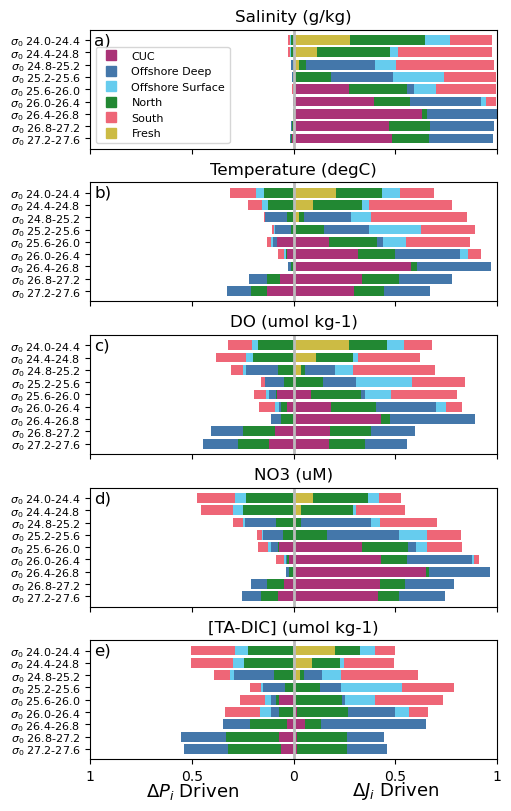

In [40]:
# without subfigures to the right
# Plotting
fig = plt.figure(constrained_layout=True, figsize=[5,8])
gs = GridSpec(5, 1, figure=fig)
ax1 = fig.add_subplot(gs[0,0])
ax3 = fig.add_subplot(gs[1,0])
ax5 = fig.add_subplot(gs[2,0])
ax7 = fig.add_subplot(gs[3,0])
ax9 = fig.add_subplot(gs[4,0])

# SALINITY
df = pd.concat([math_iso240[['range','section','saltP','saltQ']][:-1],math_iso244[['range','section','saltP','saltQ']][:-1],
    math_iso248[['range','section','saltP','saltQ']][:-1],math_iso252[['range','section','saltP','saltQ']][:-1],
    math_iso256[['range','section','saltP','saltQ']][:-1],math_iso260[['range','section','saltP','saltQ']][:-1],
    math_iso264[['range','section','saltP','saltQ']][:-1],math_iso268[['range','section','saltP','saltQ']][:-1],
    math_iso272[['range','section','saltP','saltQ']][:-1]])
combined_stacked_bar_ISO(df,'Salinity (g/kg)',ax1,False)

# TEMPERATURE
df = pd.concat([math_iso240[['range','section','tempP','tempQ']][:-1],math_iso244[['range','section','tempP','tempQ']][:-1],
    math_iso248[['range','section','tempP','tempQ']][:-1],math_iso252[['range','section','tempP','tempQ']][:-1],
    math_iso256[['range','section','tempP','tempQ']][:-1],math_iso260[['range','section','tempP','tempQ']][:-1],
    math_iso264[['range','section','tempP','tempQ']][:-1],math_iso268[['range','section','tempP','tempQ']][:-1],
    math_iso272[['range','section','tempP','tempQ']][:-1]])
combined_stacked_bar_ISO(df,'Temperature (degC)',ax3,False)

# DO
df = pd.concat([math_iso240[['range','section','DOP','DOQ']][:-1],math_iso244[['range','section','DOP','DOQ']][:-1],
    math_iso248[['range','section','DOP','DOQ']][:-1],math_iso252[['range','section','DOP','DOQ']][:-1],
    math_iso256[['range','section','DOP','DOQ']][:-1],math_iso260[['range','section','DOP','DOQ']][:-1],
    math_iso264[['range','section','DOP','DOQ']][:-1],math_iso268[['range','section','DOP','DOQ']][:-1],
    math_iso272[['range','section','DOP','DOQ']][:-1]])
combined_stacked_bar_ISO(df,'DO (umol kg-1)',ax5,False)

# NO3
df = pd.concat([math_iso240[['range','section','NO3P','NO3Q']][:-1],math_iso244[['range','section','NO3P','NO3Q']][:-1],
    math_iso248[['range','section','NO3P','NO3Q']][:-1],math_iso252[['range','section','NO3P','NO3Q']][:-1],
    math_iso256[['range','section','NO3P','NO3Q']][:-1],math_iso260[['range','section','NO3P','NO3Q']][:-1],
    math_iso264[['range','section','NO3P','NO3Q']][:-1],math_iso268[['range','section','NO3P','NO3Q']][:-1],
    math_iso272[['range','section','NO3P','NO3Q']][:-1]])
combined_stacked_bar_ISO(df,'NO3 (uM)',ax7,False)

# TA-DIC
df = pd.concat([math_iso240[['range','section','TADICP','TADICQ']][:-1],math_iso244[['range','section','TADICP','TADICQ']][:-1],
    math_iso248[['range','section','TADICP','TADICQ']][:-1],math_iso252[['range','section','TADICP','TADICQ']][:-1],
    math_iso256[['range','section','TADICP','TADICQ']][:-1],math_iso260[['range','section','TADICP','TADICQ']][:-1],
    math_iso264[['range','section','TADICP','TADICQ']][:-1],math_iso268[['range','section','TADICP','TADICQ']][:-1],
    math_iso272[['range','section','TADICP','TADICQ']][:-1]])
combined_stacked_bar_ISO(df,'[TA-DIC] (umol kg-1)',ax9,False)

ax9.set_xticklabels([1,0.5,0,0.5,1]);

# add text to each figure 
ax1.text(.01, .85, 'a)', ha='left', va='bottom', transform=ax1.transAxes, fontsize=12)
ax3.text(.01, .85, 'b)', ha='left', va='bottom', transform=ax3.transAxes, fontsize=12)
ax5.text(.01, .85, 'c)', ha='left', va='bottom', transform=ax5.transAxes, fontsize=12)
ax7.text(.01, .85, 'd)', ha='left', va='bottom', transform=ax7.transAxes, fontsize=12)
ax9.text(.01, .85, 'e)', ha='left', va='bottom', transform=ax9.transAxes, fontsize=12)

ax9.text(.25, -0.35, r'$\Delta P_i$ Driven', ha='center', va='bottom', transform=ax9.transAxes, fontsize=13)
ax9.text(.75, -0.35, r'$\Delta J_i$ Driven', ha='center', va='bottom', transform=ax9.transAxes, fontsize=13)

# # build legend handles    
legend_handles = []
regions = ['CUC', 'Offshore Deep', 'Offshore Surface', 'North', 'South', 'Fresh']
colours = ['#AA3377','#4477AA','#66CCEE','#228833','#EE6677','#CCBB44']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
# Add a figure-wide legend below the subplots
ax1.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)

# All together now

<>:32: SyntaxWarning: invalid escape sequence '\s'
<>:74: SyntaxWarning: invalid escape sequence '\s'
<>:114: SyntaxWarning: invalid escape sequence '\s'
<>:116: SyntaxWarning: invalid escape sequence '\s'
<>:132: SyntaxWarning: invalid escape sequence '\,'
<>:140: SyntaxWarning: invalid escape sequence '\c'
<>:148: SyntaxWarning: invalid escape sequence '\m'
<>:156: SyntaxWarning: invalid escape sequence '\,'
<>:164: SyntaxWarning: invalid escape sequence '\m'
<>:32: SyntaxWarning: invalid escape sequence '\s'
<>:74: SyntaxWarning: invalid escape sequence '\s'
<>:114: SyntaxWarning: invalid escape sequence '\s'
<>:116: SyntaxWarning: invalid escape sequence '\s'
<>:132: SyntaxWarning: invalid escape sequence '\,'
<>:140: SyntaxWarning: invalid escape sequence '\c'
<>:148: SyntaxWarning: invalid escape sequence '\m'
<>:156: SyntaxWarning: invalid escape sequence '\,'
<>:164: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_3242971/1533196614.py:32: SyntaxWarning: invalid esca

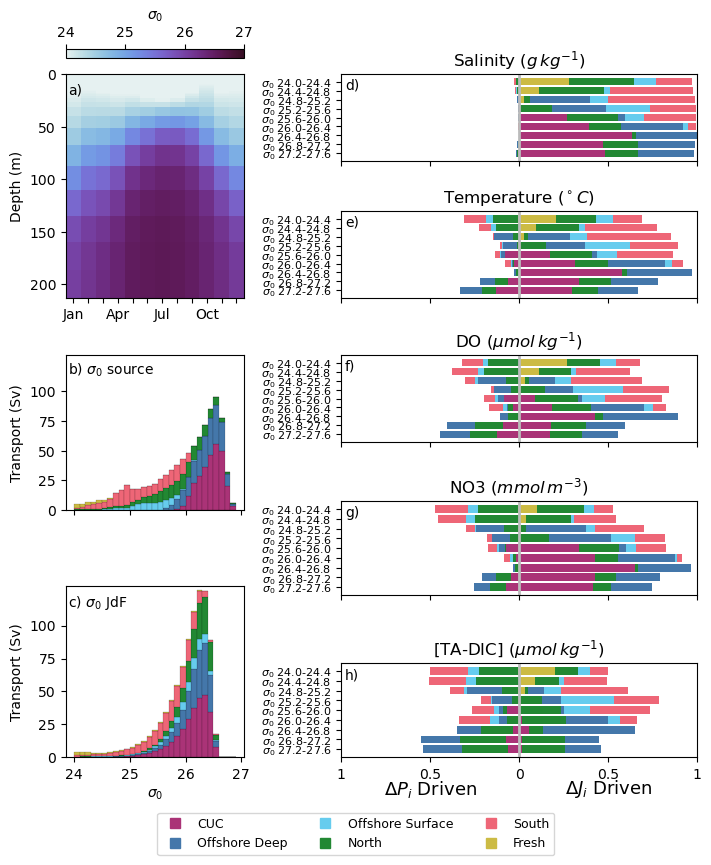

In [41]:
fig = plt.figure(constrained_layout=True, figsize=[7,2*4])
gs = GridSpec(10, 3, figure=fig)

# left side
ax1 = fig.add_subplot(gs[:4, :1])
ax2 = fig.add_subplot(gs[4:7, :1])
ax3 = fig.add_subplot(gs[7:, :1])

#right side
ax4 = fig.add_subplot(gs[:2, 1:])
ax5 = fig.add_subplot(gs[2:4, 1:])
ax6 = fig.add_subplot(gs[4:6, 1:])
ax7 = fig.add_subplot(gs[6:8, 1:])
ax8 = fig.add_subplot(gs[8:, 1:])

#############
# Hovmoller #
#############

pcm = ax1.pcolormesh(
    MM, DD, sigma.T,
    cmap=cm.cm.dense, shading='nearest',
    vmin=24,vmax=27
)

# ax.set_xlabel('Month')
ax1.set_ylabel('Depth (m)')
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(['Jan','','','Apr','','','Jul','','','Oct','',''])
ax1.invert_yaxis()  # depth increases downward
cbar = fig.colorbar(pcm, ax=ax1, pad=-0.04,location='top',orientation='horizontal')
cbar.set_label('$\sigma_0$')
ax1.text(.01, .9, 'a)', ha='left', va='bottom', transform=ax1.transAxes, fontsize=10)


##############
# Histograms #
##############
bins = np.arange(24.0, 27.0, 0.1)
# Source Boundaries
datasets = [
    iso.Fisopycnal[iso.wm == 'cuc'],
    iso.Fisopycnal[iso.wm == 'offshore deep'],
    iso.Fisopycnal[iso.wm == 'offshore surface'],
    iso.Fisopycnal[iso.wm == 'north'],
    iso.Fisopycnal[iso.wm == 'south'],
    iso.Fisopycnal[iso.wm == 'fresh']
]

weights = [
    iso.transport[iso.wm == 'cuc'],
    iso.transport[iso.wm == 'offshore deep'],
    iso.transport[iso.wm == 'offshore surface'],
    iso.transport[iso.wm == 'north'],
    iso.transport[iso.wm == 'south'],
    iso.transport[iso.wm == 'fresh']
]

colors = ['#AA3377', '#4477AA', '#66CCEE', '#228833', '#EE6677', '#CCBB44']
labels = ['CUC', 'Offshore Deep', 'Offshore Surface', 'North Shelf', 'South Shelf', 'South Brackish']

ax2.hist(
    datasets,
    bins=bins,
    weights=weights,
    color=colors,
    label=labels,
    stacked=True,
    edgecolor='black',
    linewidth = 0.1
)

ax2.set_ylabel("Transport (Sv)")
ax2.text(.01, .85, 'b) $\sigma_0$ source', ha='left', va='bottom', transform=ax2.transAxes, fontsize=10)
ax2.set_ylim([0,1300000000])
ax2.set_yticks([0,250000000,500000000,750000000,1000000000])
ax2.set_yticklabels([0,25,50,75,100])
ax2.set_xticks([24,25,26,27])
ax2.set_xticklabels([])

# Juan de Fuca 

datasets = [
    iso.Iisopycnal[iso.wm == 'cuc'],
    iso.Iisopycnal[iso.wm == 'offshore deep'],
    iso.Iisopycnal[iso.wm == 'offshore surface'],
    iso.Iisopycnal[iso.wm == 'north'],
    iso.Iisopycnal[iso.wm == 'south'],
    iso.Iisopycnal[iso.wm == 'fresh']

]

weights = [
    iso.transport[iso.wm == 'cuc'],
    iso.transport[iso.wm == 'offshore deep'],
    iso.transport[iso.wm == 'offshore surface'],
    iso.transport[iso.wm == 'north'],
    iso.transport[iso.wm == 'south'],
    iso.transport[iso.wm == 'fresh']

]

ax3.hist(
    datasets,
    bins=bins,
    weights=weights,
    color=colors,
    label=labels,
    stacked=True,
    edgecolor='black',
    linewidth = 0.1
)

ax3.set_xlabel("$\sigma_0$")
ax3.set_ylabel("Transport (Sv)")
ax3.text(.01, .85, 'c) $\sigma_0$ JdF', ha='left', va='bottom', transform=ax3.transAxes, fontsize=10)
ax3.set_ylim([0,1300000000])
ax3.set_yticks([0,250000000,500000000,750000000,1000000000])
ax3.set_yticklabels([0,25,50,75,100])
ax3.set_xticks([24,25,26,27])

###############
# Attribution #
###############

# SALINITY
df = pd.concat([math_iso240[['range','section','saltP','saltQ']][:-1],math_iso244[['range','section','saltP','saltQ']][:-1],
    math_iso248[['range','section','saltP','saltQ']][:-1],math_iso252[['range','section','saltP','saltQ']][:-1],
    math_iso256[['range','section','saltP','saltQ']][:-1],math_iso260[['range','section','saltP','saltQ']][:-1],
    math_iso264[['range','section','saltP','saltQ']][:-1],math_iso268[['range','section','saltP','saltQ']][:-1],
    math_iso272[['range','section','saltP','saltQ']][:-1]])
combined_stacked_bar_ISO(df,'Salinity ($g\,kg^{-1}$)',ax4,False)

# TEMPERATURE
df = pd.concat([math_iso240[['range','section','tempP','tempQ']][:-1],math_iso244[['range','section','tempP','tempQ']][:-1],
    math_iso248[['range','section','tempP','tempQ']][:-1],math_iso252[['range','section','tempP','tempQ']][:-1],
    math_iso256[['range','section','tempP','tempQ']][:-1],math_iso260[['range','section','tempP','tempQ']][:-1],
    math_iso264[['range','section','tempP','tempQ']][:-1],math_iso268[['range','section','tempP','tempQ']][:-1],
    math_iso272[['range','section','tempP','tempQ']][:-1]])
combined_stacked_bar_ISO(df,'Temperature ($^\circ C$)',ax5,False)

# DO
df = pd.concat([math_iso240[['range','section','DOP','DOQ']][:-1],math_iso244[['range','section','DOP','DOQ']][:-1],
    math_iso248[['range','section','DOP','DOQ']][:-1],math_iso252[['range','section','DOP','DOQ']][:-1],
    math_iso256[['range','section','DOP','DOQ']][:-1],math_iso260[['range','section','DOP','DOQ']][:-1],
    math_iso264[['range','section','DOP','DOQ']][:-1],math_iso268[['range','section','DOP','DOQ']][:-1],
    math_iso272[['range','section','DOP','DOQ']][:-1]])
combined_stacked_bar_ISO(df,'DO ($\mu mol \,kg^{-1}$)',ax6,False)

# NO3
df = pd.concat([math_iso240[['range','section','NO3P','NO3Q']][:-1],math_iso244[['range','section','NO3P','NO3Q']][:-1],
    math_iso248[['range','section','NO3P','NO3Q']][:-1],math_iso252[['range','section','NO3P','NO3Q']][:-1],
    math_iso256[['range','section','NO3P','NO3Q']][:-1],math_iso260[['range','section','NO3P','NO3Q']][:-1],
    math_iso264[['range','section','NO3P','NO3Q']][:-1],math_iso268[['range','section','NO3P','NO3Q']][:-1],
    math_iso272[['range','section','NO3P','NO3Q']][:-1]])
combined_stacked_bar_ISO(df,'NO3 ($mmol \, m^{-3}$)',ax7,False)

# TA-DIC
df = pd.concat([math_iso240[['range','section','TADICP','TADICQ']][:-1],math_iso244[['range','section','TADICP','TADICQ']][:-1],
    math_iso248[['range','section','TADICP','TADICQ']][:-1],math_iso252[['range','section','TADICP','TADICQ']][:-1],
    math_iso256[['range','section','TADICP','TADICQ']][:-1],math_iso260[['range','section','TADICP','TADICQ']][:-1],
    math_iso264[['range','section','TADICP','TADICQ']][:-1],math_iso268[['range','section','TADICP','TADICQ']][:-1],
    math_iso272[['range','section','TADICP','TADICQ']][:-1]])
combined_stacked_bar_ISO(df,'[TA-DIC] ($\mu mol \,kg^{-1}$)',ax8,False)
ax8.set_xticklabels([1,0.5,0,0.5,1]);

# add text to each figure 
ax4.text(.01, .8, 'd)', ha='left', va='bottom', transform=ax4.transAxes, fontsize=10)
ax5.text(.01, .8, 'e)', ha='left', va='bottom', transform=ax5.transAxes, fontsize=10)
ax6.text(.01, .8, 'f)', ha='left', va='bottom', transform=ax6.transAxes, fontsize=10)
ax7.text(.01, .8, 'g)', ha='left', va='bottom', transform=ax7.transAxes, fontsize=10)
ax8.text(.01, .8, 'h)', ha='left', va='bottom', transform=ax8.transAxes, fontsize=10)

ax8.text(.25, -0.45, r'$\Delta P_i$ Driven', ha='center', va='bottom', transform=ax8.transAxes, fontsize=13)
ax8.text(.75, -0.45, r'$\Delta J_i$ Driven', ha='center', va='bottom', transform=ax8.transAxes, fontsize=13)

# # build legend handles    
legend_handles = []
regions = ['CUC', 'Offshore Deep', 'Offshore Surface', 'North', 'South', 'Fresh']
colours = ['#AA3377','#4477AA','#66CCEE','#228833','#EE6677','#CCBB44']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
# Add a figure-wide legend below the subplots
fig.legend(handles=legend_handles, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.07), frameon=True,fontsize=9)

# plt.savefig("/ocean/rbeutel/MOAD/biogeo_paper/PI_BIOGEO_PAPER/model/figures/isopycnal.jpg",bbox_inches='tight')


<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:66: SyntaxWarning: invalid escape sequence '\s'
<>:71: SyntaxWarning: invalid escape sequence '\s'
<>:107: SyntaxWarning: invalid escape sequence '\s'
<>:109: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:66: SyntaxWarning: invalid escape sequence '\s'
<>:71: SyntaxWarning: invalid escape sequence '\s'
<>:107: SyntaxWarning: invalid escape sequence '\s'
<>:109: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_3242971/953289869.py:24: SyntaxWarning: invalid escape sequence '\s'
  cbar.set_label('$\sigma_0$')
/tmp/ipykernel_3242971/953289869.py:66: SyntaxWarning: invalid escape sequence '\s'
  ax2.text(.01, .85, 'b) $\sigma_0$ source', ha='left', va='bottom', transform=ax2.transAxes, fontsize=10)
/tmp/ipykernel_3242971/953289869.py:71: SyntaxWarning: invalid escape sequence '\s'
  ax2.set_xlabel("$\sigma_0$")
/tmp/ipykernel_3242971/953289869.py:107: SyntaxWarning: invalid e

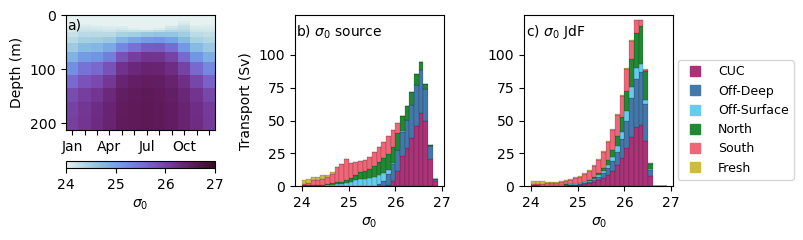

In [42]:
# or should it be two figures?

fig, ax = plt.subplots(1,3,figsize=[7,2.5])
ax1 = ax[0]
ax2 = ax[1]
ax3 = ax[2]

#############
# Hovmoller #
#############

pcm = ax1.pcolormesh(
    MM, DD, sigma.T,
    cmap=cm.cm.dense, shading='nearest',
    vmin=24,vmax=27
)

# ax.set_xlabel('Month')
ax1.set_ylabel('Depth (m)')
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(['Jan','','','Apr','','','Jul','','','Oct','',''])
ax1.invert_yaxis()  # depth increases downward
cbar = fig.colorbar(pcm, ax=ax1, pad=0.18,location='bottom',orientation='horizontal')
cbar.set_label('$\sigma_0$')
ax1.text(.01, .85, 'a)', ha='left', va='bottom', transform=ax1.transAxes, fontsize=10)


##############
# Histograms #
##############
bins = np.arange(24.0, 27.0, 0.1)
# Source Boundaries
datasets = [
    iso.Fisopycnal[iso.wm == 'cuc'],
    iso.Fisopycnal[iso.wm == 'offshore deep'],
    iso.Fisopycnal[iso.wm == 'offshore surface'],
    iso.Fisopycnal[iso.wm == 'north'],
    iso.Fisopycnal[iso.wm == 'south'],
    iso.Fisopycnal[iso.wm == 'fresh']
]

weights = [
    iso.transport[iso.wm == 'cuc'],
    iso.transport[iso.wm == 'offshore deep'],
    iso.transport[iso.wm == 'offshore surface'],
    iso.transport[iso.wm == 'north'],
    iso.transport[iso.wm == 'south'],
    iso.transport[iso.wm == 'fresh']
]

colors = ['#AA3377', '#4477AA', '#66CCEE', '#228833', '#EE6677', '#CCBB44']
labels = ['CUC', 'Offshore Deep', 'Offshore Surface', 'North Shelf', 'South Shelf', 'South Brackish']

ax2.hist(
    datasets,
    bins=bins,
    weights=weights,
    color=colors,
    label=labels,
    stacked=True,
    edgecolor='black',
    linewidth = 0.1
)

ax2.set_ylabel("Transport (Sv)")
ax2.text(.01, .85, 'b) $\sigma_0$ source', ha='left', va='bottom', transform=ax2.transAxes, fontsize=10)
ax2.set_ylim([0,1300000000])
ax2.set_yticks([0,250000000,500000000,750000000,1000000000])
ax2.set_yticklabels([0,25,50,75,100])
ax2.set_xticks([24,25,26,27])
ax2.set_xlabel("$\sigma_0$")


# Juan de Fuca 

datasets = [
    iso.Iisopycnal[iso.wm == 'cuc'],
    iso.Iisopycnal[iso.wm == 'offshore deep'],
    iso.Iisopycnal[iso.wm == 'offshore surface'],
    iso.Iisopycnal[iso.wm == 'north'],
    iso.Iisopycnal[iso.wm == 'south'],
    iso.Iisopycnal[iso.wm == 'fresh']

]

weights = [
    iso.transport[iso.wm == 'cuc'],
    iso.transport[iso.wm == 'offshore deep'],
    iso.transport[iso.wm == 'offshore surface'],
    iso.transport[iso.wm == 'north'],
    iso.transport[iso.wm == 'south'],
    iso.transport[iso.wm == 'fresh']

]

ax3.hist(
    datasets,
    bins=bins,
    weights=weights,
    color=colors,
    label=labels,
    stacked=True,
    edgecolor='black',
    linewidth = 0.1
)

ax3.set_xlabel("$\sigma_0$")
# ax3.set_ylabel("Transport (Sv)")
ax3.text(.01, .85, 'c) $\sigma_0$ JdF', ha='left', va='bottom', transform=ax3.transAxes, fontsize=10)
ax3.set_ylim([0,1300000000])
ax3.set_yticks([0,250000000,500000000,750000000,1000000000])
ax3.set_yticklabels([0,25,50,75,100])
ax3.set_xticks([24,25,26,27])

# # build legend handles    
legend_handles = []
regions = ['CUC', 'Off-Deep', 'Off-Surface', 'North', 'South', 'Fresh']
colours = ['#AA3377','#4477AA','#66CCEE','#228833','#EE6677','#CCBB44']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
# Add a legend to the right of the subplots
fig.legend(handles=legend_handles, loc='center right', ncol=1, bbox_to_anchor=(1.15, 0.5), frameon=True,fontsize=9)

plt.tight_layout()

plt.savefig("/ocean/rbeutel/MOAD/biogeo_paper/PI_BIOGEO_PAPER/model/figures/isopycnal_hist.jpg",bbox_inches='tight')


<>:20: SyntaxWarning: invalid escape sequence '\,'
<>:51: SyntaxWarning: invalid escape sequence '\c'
<>:79: SyntaxWarning: invalid escape sequence '\m'
<>:107: SyntaxWarning: invalid escape sequence '\,'
<>:135: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\,'
<>:51: SyntaxWarning: invalid escape sequence '\c'
<>:79: SyntaxWarning: invalid escape sequence '\m'
<>:107: SyntaxWarning: invalid escape sequence '\,'
<>:135: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_3242971/3453645712.py:20: SyntaxWarning: invalid escape sequence '\,'
  combined_stacked_bar_ISO(df,'Salinity ($g\,kg^{-1}$)',ax4,False)
/tmp/ipykernel_3242971/3453645712.py:51: SyntaxWarning: invalid escape sequence '\c'
  combined_stacked_bar_ISO(df,'Temperature ($^\circ C$)',ax5,False)
/tmp/ipykernel_3242971/3453645712.py:79: SyntaxWarning: invalid escape sequence '\m'
  combined_stacked_bar_ISO(df,'DO ($\mu mol \,kg^{-1}$)',ax6,False)
/tmp/ipykernel_3242971/34536

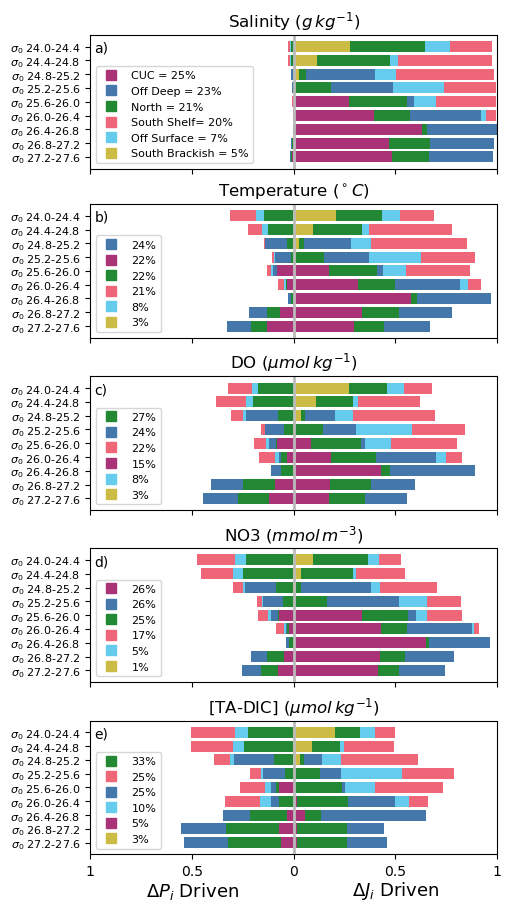

In [65]:
###############
# Attribution #
###############
sections = ['cuc', 'off_d', 'off_s', 'north', 'south', 'fresh']

fig = plt.figure(constrained_layout=True, figsize=[5,9])
gs = GridSpec(5, 1, figure=fig)
ax4 = fig.add_subplot(gs[0,0])
ax5 = fig.add_subplot(gs[1,0])
ax6 = fig.add_subplot(gs[2,0])
ax7 = fig.add_subplot(gs[3,0])
ax8 = fig.add_subplot(gs[4,0])

# SALINITY
df = pd.concat([math_iso240[['range','section','saltP','saltQ']][:-1],math_iso244[['range','section','saltP','saltQ']][:-1],
    math_iso248[['range','section','saltP','saltQ']][:-1],math_iso252[['range','section','saltP','saltQ']][:-1],
    math_iso256[['range','section','saltP','saltQ']][:-1],math_iso260[['range','section','saltP','saltQ']][:-1],
    math_iso264[['range','section','saltP','saltQ']][:-1],math_iso268[['range','section','saltP','saltQ']][:-1],
    math_iso272[['range','section','saltP','saltQ']][:-1]])
combined_stacked_bar_ISO(df,'Salinity ($g\,kg^{-1}$)',ax4,False)

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('range')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']
perc = [int(np.round(np.nanmean(np.nansum([df.normP[df.section==region],df.normQ[df.section==region],df.normX[df.section==region]],axis=0)),2)*100) for region in sections]


legend_handles = []
regions = ['CUC = {}%'.format(perc[0]),'Off Deep = {}%'.format(perc[1]), 'North = {}%'.format(perc[3]), 'South Shelf= {}%'.format(perc[4]), 
           'Off Surface = {}%'.format(perc[2]), 'South Brackish = {}%'.format(perc[5])]
colours = ['#AA3377','#4477AA','#228833','#EE6677','#66CCEE','#CCBB44']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
# Add a figure-wide legend below the subplots
ax4.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)


# TEMPERATURE
df = pd.concat([math_iso240[['range','section','tempP','tempQ']][:-1],math_iso244[['range','section','tempP','tempQ']][:-1],
    math_iso248[['range','section','tempP','tempQ']][:-1],math_iso252[['range','section','tempP','tempQ']][:-1],
    math_iso256[['range','section','tempP','tempQ']][:-1],math_iso260[['range','section','tempP','tempQ']][:-1],
    math_iso264[['range','section','tempP','tempQ']][:-1],math_iso268[['range','section','tempP','tempQ']][:-1],
    math_iso272[['range','section','tempP','tempQ']][:-1]])
combined_stacked_bar_ISO(df,'Temperature ($^\circ C$)',ax5,False)

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('range')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']
perc = [int(np.round(np.nanmean(np.nansum([df.normP[df.section==region],df.normQ[df.section==region],df.normX[df.section==region]],axis=0)),2)*100) for region in sections]

legend_handles = []
regions = ['{}%'.format(perc[1]), '{}%'.format(perc[0]),  '{}%'.format(perc[3]), '{}%'.format(perc[4]), 
                   '{}%'.format(perc[2]), '{}%'.format(perc[5])]
colours = ['#4477AA','#AA3377','#228833','#EE6677','#66CCEE','#CCBB44']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
ax5.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)

# DO
df = pd.concat([math_iso240[['range','section','DOP','DOQ']][:-1],math_iso244[['range','section','DOP','DOQ']][:-1],
    math_iso248[['range','section','DOP','DOQ']][:-1],math_iso252[['range','section','DOP','DOQ']][:-1],
    math_iso256[['range','section','DOP','DOQ']][:-1],math_iso260[['range','section','DOP','DOQ']][:-1],
    math_iso264[['range','section','DOP','DOQ']][:-1],math_iso268[['range','section','DOP','DOQ']][:-1],
    math_iso272[['range','section','DOP','DOQ']][:-1]])
combined_stacked_bar_ISO(df,'DO ($\mu mol \,kg^{-1}$)',ax6,False)

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('range')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']
perc = [int(np.round(np.nanmean(np.nansum([df.normP[df.section==region],df.normQ[df.section==region],df.normX[df.section==region]],axis=0)),2)*100) for region in sections]

legend_handles = []
regions = ['{}%'.format(perc[3]), '{}%'.format(perc[1]), '{}%'.format(perc[4]),'{}%'.format(perc[0]),
                   '{}%'.format(perc[2]),  '{}%'.format(perc[5])]
colours = ['#228833','#4477AA','#EE6677','#AA3377','#66CCEE','#CCBB44',]
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
ax6.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)

# NO3
df = pd.concat([math_iso240[['range','section','NO3P','NO3Q']][:-1],math_iso244[['range','section','NO3P','NO3Q']][:-1],
    math_iso248[['range','section','NO3P','NO3Q']][:-1],math_iso252[['range','section','NO3P','NO3Q']][:-1],
    math_iso256[['range','section','NO3P','NO3Q']][:-1],math_iso260[['range','section','NO3P','NO3Q']][:-1],
    math_iso264[['range','section','NO3P','NO3Q']][:-1],math_iso268[['range','section','NO3P','NO3Q']][:-1],
    math_iso272[['range','section','NO3P','NO3Q']][:-1]])
combined_stacked_bar_ISO(df,'NO3 ($mmol \, m^{-3}$)',ax7,False)

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('range')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']
perc = [int(np.round(np.nanmean(np.nansum([df.normP[df.section==region],df.normQ[df.section==region],df.normX[df.section==region]],axis=0)),2)*100) for region in sections]

legend_handles = []
regions = ['{}%'.format(perc[0]),'{}%'.format(perc[1]), '{}%'.format(perc[3]),  '{}%'.format(perc[4]),
                   '{}%'.format(perc[2]), '{}%'.format(perc[5])]
colours = ['#AA3377','#4477AA','#228833','#EE6677','#66CCEE','#CCBB44']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
ax7.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)

# TA-DIC
df = pd.concat([math_iso240[['range','section','TADICP','TADICQ']][:-1],math_iso244[['range','section','TADICP','TADICQ']][:-1],
    math_iso248[['range','section','TADICP','TADICQ']][:-1],math_iso252[['range','section','TADICP','TADICQ']][:-1],
    math_iso256[['range','section','TADICP','TADICQ']][:-1],math_iso260[['range','section','TADICP','TADICQ']][:-1],
    math_iso264[['range','section','TADICP','TADICQ']][:-1],math_iso268[['range','section','TADICP','TADICQ']][:-1],
    math_iso272[['range','section','TADICP','TADICQ']][:-1]])
combined_stacked_bar_ISO(df,'[TA-DIC] ($\mu mol \,kg^{-1}$)',ax8,False)
ax8.set_xticklabels([1,0.5,0,0.5,1]);

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('range')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']
perc = [int(np.round(np.nanmean(np.nansum([df.normP[df.section==region],df.normQ[df.section==region],df.normX[df.section==region]],axis=0)),2)*100) for region in sections]

legend_handles = []
regions = [ '{}%'.format(perc[3]), '{}%'.format(perc[4]), '{}%'.format(perc[1]),'{}%'.format(perc[2]),
                     '{}%'.format(perc[0]),'{}%'.format(perc[5])]
colours = ['#228833','#EE6677','#4477AA','#66CCEE','#AA3377','#CCBB44',]
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
ax8.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)

# add text to each figure 
ax4.text(.01, .85, 'a)', ha='left', va='bottom', transform=ax4.transAxes, fontsize=10)
ax5.text(.01, .85, 'b)', ha='left', va='bottom', transform=ax5.transAxes, fontsize=10)
ax6.text(.01, .85, 'c)', ha='left', va='bottom', transform=ax6.transAxes, fontsize=10)
ax7.text(.01, .85, 'd)', ha='left', va='bottom', transform=ax7.transAxes, fontsize=10)
ax8.text(.01, .85, 'e)', ha='left', va='bottom', transform=ax8.transAxes, fontsize=10)

ax8.text(.25, -0.35, r'$\Delta P_i$ Driven', ha='center', va='bottom', transform=ax8.transAxes, fontsize=13)
ax8.text(.75, -0.35, r'$\Delta J_i$ Driven', ha='center', va='bottom', transform=ax8.transAxes, fontsize=13)

plt.savefig("/ocean/rbeutel/MOAD/biogeo_paper/PI_BIOGEO_PAPER/model/figures/isopycnal_attr.jpg",bbox_inches='tight')


In [ ]:
# property versus dynamics for each tracer

df = pd.concat([math_iso240[['range','section','saltP','saltQ']][:-1],math_iso244[['range','section','saltP','saltQ']][:-1],
    math_iso248[['range','section','saltP','saltQ']][:-1],math_iso252[['range','section','saltP','saltQ']][:-1],
    math_iso256[['range','section','saltP','saltQ']][:-1],math_iso260[['range','section','saltP','saltQ']][:-1],
    math_iso264[['range','section','saltP','saltQ']][:-1],math_iso268[['range','section','saltP','saltQ']][:-1],
    math_iso272[['range','section','saltP','saltQ']][:-1]])

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('range')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']

ranges = list(set(df.range))
Psum = [np.sum(df.normP[df.range == r]) for r in ranges]
Qsum = [np.sum(df.normQ[df.range == r]) for r in ranges]
Xsum = [np.sum(df.normX[df.range == r]) for r in ranges]
print("Salinity: total P mean = {} ({}), Q mean = {}, ({})".format(np.round(np.nanmean(Psum),4),np.round(np.nanstd(Psum),4),np.round(np.nanmean(Qsum),4),np.round(np.nanstd(Qsum),4)))


Salinity: total P mean = 0.0136 (0.0084), Q mean = 0.9729, (0.0167)


In [75]:
df = pd.concat([math_iso240[['range','section','tempP','tempQ']][:-1],math_iso244[['range','section','tempP','tempQ']][:-1],
    math_iso248[['range','section','tempP','tempQ']][:-1],math_iso252[['range','section','tempP','tempQ']][:-1],
    math_iso256[['range','section','tempP','tempQ']][:-1],math_iso260[['range','section','tempP','tempQ']][:-1],
    math_iso264[['range','section','tempP','tempQ']][:-1],math_iso268[['range','section','tempP','tempQ']][:-1],
    math_iso272[['range','section','tempP','tempQ']][:-1]]);

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('range')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']

ranges = list(set(df.range))
Psum = [np.sum(df.normP[df.range == r]) for r in ranges]
Qsum = [np.sum(df.normQ[df.range == r]) for r in ranges]
Xsum = [np.sum(df.normX[df.range == r]) for r in ranges]
print("Temperature: total P mean = {} ({}), Q mean = {}, ({})".format(np.round(np.nanmean(Psum),4),np.round(np.nanstd(Psum),4),np.round(np.nanmean(Qsum),4),np.round(np.nanstd(Qsum),4)))


Temperature: total P mean = 0.144 (0.0698), Q mean = 0.712, (0.1396)


In [76]:
df = pd.concat([math_iso240[['range','section','DOP','DOQ']][:-1],math_iso244[['range','section','DOP','DOQ']][:-1],
    math_iso248[['range','section','DOP','DOQ']][:-1],math_iso252[['range','section','DOP','DOQ']][:-1],
    math_iso256[['range','section','DOP','DOQ']][:-1],math_iso260[['range','section','DOP','DOQ']][:-1],
    math_iso264[['range','section','DOP','DOQ']][:-1],math_iso268[['range','section','DOP','DOQ']][:-1],
    math_iso272[['range','section','DOP','DOQ']][:-1]])

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('range')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']

ranges = list(set(df.range))
Psum = [np.sum(df.normP[df.range == r]) for r in ranges]
Qsum = [np.sum(df.normQ[df.range == r]) for r in ranges]
Xsum = [np.sum(df.normX[df.range == r]) for r in ranges]
print("DO: total P mean = {} ({}), Q mean = {}, ({})".format(np.round(np.nanmean(Psum),4),np.round(np.nanstd(Psum),4),np.round(np.nanmean(Qsum),4),np.round(np.nanstd(Qsum),4)))


DO: total P mean = 0.2112 (0.0709), Q mean = 0.5777, (0.1418)


In [77]:
df = pd.concat([math_iso240[['range','section','NO3P','NO3Q']][:-1],math_iso244[['range','section','NO3P','NO3Q']][:-1],
    math_iso248[['range','section','NO3P','NO3Q']][:-1],math_iso252[['range','section','NO3P','NO3Q']][:-1],
    math_iso256[['range','section','NO3P','NO3Q']][:-1],math_iso260[['range','section','NO3P','NO3Q']][:-1],
    math_iso264[['range','section','NO3P','NO3Q']][:-1],math_iso268[['range','section','NO3P','NO3Q']][:-1],
    math_iso272[['range','section','NO3P','NO3Q']][:-1]])

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('range')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']

ranges = list(set(df.range))
Psum = [np.sum(df.normP[df.range == r]) for r in ranges]
Qsum = [np.sum(df.normQ[df.range == r]) for r in ranges]
Xsum = [np.sum(df.normX[df.range == r]) for r in ranges]
print("NO3: total P mean = {} ({}), Q mean = {}, ({})".format(np.round(np.nanmean(Psum),4),np.round(np.nanstd(Psum),4),np.round(np.nanmean(Qsum),4),np.round(np.nanstd(Qsum),4)))


NO3: total P mean = 0.1842 (0.0901), Q mean = 0.6316, (0.1802)


In [78]:
df = pd.concat([math_iso240[['range','section','TADICP','TADICQ']][:-1],math_iso244[['range','section','TADICP','TADICQ']][:-1],
    math_iso248[['range','section','TADICP','TADICQ']][:-1],math_iso252[['range','section','TADICP','TADICQ']][:-1],
    math_iso256[['range','section','TADICP','TADICQ']][:-1],math_iso260[['range','section','TADICP','TADICQ']][:-1],
    math_iso264[['range','section','TADICP','TADICQ']][:-1],math_iso268[['range','section','TADICP','TADICQ']][:-1],
    math_iso272[['range','section','TADICP','TADICQ']][:-1]])

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('range')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']

ranges = list(set(df.range))
Psum = [np.sum(df.normP[df.range == r]) for r in ranges]
Qsum = [np.sum(df.normQ[df.range == r]) for r in ranges]
Xsum = [np.sum(df.normX[df.range == r]) for r in ranges]
print("TA-DIC: total P mean = {} ({}), Q mean = {}, ({})".format(np.round(np.nanmean(Psum),4),np.round(np.nanstd(Psum),4),np.round(np.nanmean(Qsum),4),np.round(np.nanstd(Qsum),4)))

TA-DIC: total P mean = 0.2843 (0.0613), Q mean = 0.4315, (0.1225)
